In [51]:
import numpy as np
from symplectic_encoding import generate_a_symplectic_encoding_matrix
from qecsim import paulitools as pt
import matplotlib.pyplot as plt

## In this notebook, we wish to compute the rate of a code composed of concatenating a finite-sized stabilizer code with a random stabilizer code, in a scheme similar to the one proposed in [1], where we replace repetition code with other stabilizer codes. 

Consider concatenating an $[[n,k,d]]$ with a random stabilizer code, used on a noisy Pauli channel $\mathcal{E}$, the resulting rate will be: $$\frac{1}{n}\sum_{x\in\{0,1\}^{n-k}}p(\text{syndrome}=x)I_c(\mathcal{E}^{x}), $$ where $I_c$ is the coherent information of the channel, and $\mathcal{E}^x$ is the induced channel when the syndrome $x$ is measured.
[1] Degenerate Quantum Codes for Pauli Channels. Graeme Smith, John A. Smolin. https://arxiv.org/abs/quant-ph/0604107.

For a general $[[n,k,d]]$ stabilizer code, the effective channel can be computed by finding the probability of each logical class given the syndrome $P(L=l|x)$. The coherent information of the induced channel will be at least $k-\text{entropy}[P(L|x)]$.
Thus, our task is to compute the probability of each logical class given the syndrome $P(L=l|x) = \frac{P(L=l,x)}{\sum_{l\in \text{Logicals}}P(L=l,x)}$.
Let $t(x)$ denote the true error corresponding to the syndrome $x$. Let $a*b$ denote the matrix product of $a,b$. We need to compute $P(L=l,x) = \sum_{s\in \text{Stabilizers}}P(E=l*s*t(x)).$ We can also do this more efficiently in terms of the symplectic formalism, where Pauli strings of length $n$ are represented by $2n$-dimensional binary vectors, and multiplying two Pauli strings is equivalent to adding their symplectic representations (modulo 2).

In [52]:
def entropy(p):
    """
    Computes the entropy of a probability distribution

    Args:
        p: an array of probabilities that sum to 1

    Returns: the entropy of the distribution

    """
    # Make sure input is a numpy array
    p = np.array(p)
    # Make sure the distribution sums to 1
    assert np.isclose(p.sum(), 1.0)
    # Make sure all probabilities are non-negative
    assert np.all(np.isclose(p-abs(p),0))

    # Compute the entropy
    e = 0
    for pi in p:
        if not np.isclose(pi,0):
            e -= pi * np.log2(pi)
    #assert(e>=0)
    return e


#### First: express the matrix of stabilizer generators of some code in the symplectic representation (for e.g., a code from http://www.codetables.de/). 

In [53]:
# [[4,2,2]] code https://errorcorrectionzoo.org/c/stab_4_2_2
data_str = """
[1 1 1 1|0 0 0 0]
[0 0 0 0|1 1 1 1]
"""
# Remove brackets and split into rows
rows = data_str.strip().split('\n')
# Convert each row into a single integer array
arrays = []
for row in rows:
    array = np.array(list(map(int, row.strip('[]').replace('|', ' ').split())))
    arrays.append(array)

stabilizers_bsf=arrays #stabilizer generators in binary symplectic form

n = len(stabilizers_bsf[0])//2
n_k = len(stabilizers_bsf)
k = n-n_k
print('n:',n,'k:',k)

n: 4 k: 2


#### Next, we generate the symplectic encoding matrix $C$ for the code. Let $x\in \mathbb{F}_2^{2n}$ be a row vector which is the symplectic representation of an unencoded Pauli operator input. The encoded Pauli operator is given by $xC$. This corresponds to applying the corresponding encoding unitary $U_C$ to the corresponding unencoded Pauli operator $P_x$, obtaining $U_C P_x U_C^\dagger$.

In [54]:
C = generate_a_symplectic_encoding_matrix(n, k, stabilizers_bsf)

### For $n$ qubits, there are $4^n$ Pauli strings. 
<pre> Unencoded $P_x$ or $x$                   Encoded $U_C P_x U_C^\dagger$ or $xC$                  
----------------------------------------------------------------------------------------------
$X_1,\dots,X_k$                               Generators of X-Logicals 
$X_{k+1},\dots,X_n$                           Generators of 'True' Errors 
$Z_1,\dots,Z_k$                               Generators of Z-Logicals
$Z_{k+1},\dots,Z_n$                           Generators of Stabilizers
 </pre>
 ### We compute these generators in the next step:

In [55]:
def logical_generators_bsf(C,k):
    """
    returns the generators of logical operators for a stabilizer code with a symplectic encoding matrix C of size 2n*2n, 
    where n is the number of physical qubits in the code.
    :param C: symplectic encoding matrix
    :param k: number of logical qubits
    :return: list of generatots of logical operators in binary symplectic form.
    """
    n = C.shape[0]//2
    Logicals = []
    for i in range(k):
        XLogicalUnenc = pt.pauli_to_bsf('I'*i+'X'+'I'*(n-i-1))
        XLogical_encoded = (XLogicalUnenc@C)%2
        Logicals.append(XLogical_encoded)
        
        ZLogicalUnenc = pt.pauli_to_bsf('I'*i+'Z'+'I'*(n-i-1))
        ZLogical_encoded = (ZLogicalUnenc@C)%2
        Logicals.append(ZLogical_encoded)
        
    return Logicals

def true_errors_generators_bsf(C,k):
    """
    returns the generators of true error operators for a stabilizer code with a symplectic encoding matrix C of size 2n*2n, 
    where n is the number of physical qubits in the code.
    :param C: symplectic encoding matrix
    :param k: number of logical qubits
    :return: list of generators of true error operators in binary symplectic form.
    """
    n = C.shape[0]//2
    TrueErrors = []
    for i in range(k,n):
        TrueErrorUnenc = pt.pauli_to_bsf('I'*i+'X'+'I'*(n-i-1))
        TrueError_encoded = (TrueErrorUnenc@C)%2
        TrueErrors.append(TrueError_encoded)     
    return TrueErrors

In [56]:
true_error_generators = true_errors_generators_bsf(C, k)
logical_generators = logical_generators_bsf(C, k)
stabilizer_generators = stabilizers_bsf

In [57]:
def generate_group_element(group_generators, idx):
    """
    returns a group element from a list of group generators.
    :param group_generators: list of group generators
    :param idx: index of the group element to be generated
    :return: group element
    """
    group_element = np.zeros(len(group_generators[0]),dtype=int)
    i = 0
    while idx>=1:
        if idx%2 == 1:
            group_element = (group_element+group_generators[i])%2
        idx = idx//2
        i += 1

    return group_element

In [58]:
def wLST(L,S,T): 
    # Computes the number of X's, Y's and Z's in a Pauli string E = L*S*T
    E = (L+S+T)%2
    E_X = E[:len(E)//2]
    E_Z = E[len(E)//2:]
    E_Y = E_X*E_Z
    nY = np.sum(E_Y)
    nX = np.sum(E_X)-nY
    nZ = np.sum(E_Z)-nY
    return nX,nY,nZ

In [59]:
def induced_channel(true_error, logical_generators, stabilizer_generators, px, py, pz):
    
    pLT = np.zeros(2**len(logical_generators))
    n = len(true_error)//2
    
    for idL in range(2**len(logical_generators)):
        L = generate_group_element(logical_generators, idL)
        for idS in range(2**len(stabilizer_generators)):
            S = generate_group_element(stabilizer_generators, idS)
            nX,nY,nZ = wLST(L,S,true_error)
            pLT[idL] += (1-px-py-pz)**(n-nX-nY-nZ)*px**nX*py**nY*pz**nZ     
    pT = sum(pLT)
    
    if(pT == 0):
        return 0, pLT
    
    pLgivenT = np.array([p/pT for p in pLT])
    return pT, pLgivenT

In [60]:
def rate(true_error_generators, logical_generators, stabilizer_generators, px, py, pz):    
    n = len(true_error_generators[0])//2
    k = len(logical_generators)//2
    R = 0
    for id_t in range(2**len(true_error_generators)):
        true_error = generate_group_element(true_error_generators, id_t)
        pT, pLgivenT = induced_channel(true_error, logical_generators, stabilizer_generators, px, py, pz)
    
        if(pT>0):
            R += pT*(k-entropy(pLgivenT))
    
    R = R/n
    return R
        
        

We now plot the rates for the concatenation of a [[4,2,2]] code with a random stabilizer code, and the hashing rate when used over 
a depolarizing channel $$ \rho\rightarrow (1-p) \rho + p/3 (X \rho X + Y \rho Y +Z \rho Z).$$

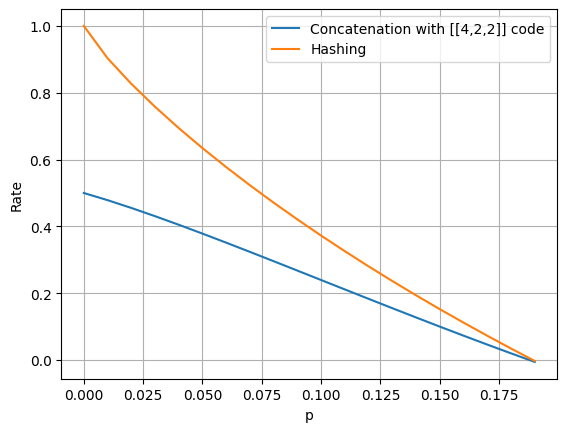

In [61]:
prange = np.arange(0,0.2,0.01)
rate_concatenation = [] 
hashing = []
for p in prange:
    rate_concatenation.append(rate(true_error_generators, logical_generators, stabilizer_generators, p/3, p/3, p/3))
    hashing.append(1-entropy([1-p,p/3,p/3,p/3]))
plt.plot(prange, rate_concatenation, label='Concatenation with [[4,2,2]] code')
plt.plot(prange, hashing, label='Hashing')
plt.legend()
plt.xlabel('p')
plt.ylabel('Rate')
plt.grid()
